SVD PORTFOLIO STRATEGY - STRESS TEST PROFILES
Professional Financial Reporting with Adaptive Optimization
Using fallback ticker list...
✓ Loaded 223 stocks with 9360 trading days

Universe: 223 stocks, 9359 trading days
Date range: 1988-05-03 to 2025-06-27
SVD Rank: ADAPTIVE (validated from range 4-5)

STRESS TEST PROFILES: 3 strategies + Benchmark

[1/3] Running: Aggresive
    Params: Train=12m, Test=1m, Short=0.0, Mom=0.8
    ✓ Sharpe=0.687, Return=17.69%, Vol=19.93%, MaxDD=-50.41%
    ✓ Avg k=4.3 ± 0.5

[2/3] Running: Very Defensive
    Params: Train=60m, Test=6m, Short=0.0, Mom=0.0
    ✓ Sharpe=0.880, Return=20.12%, Vol=18.31%, MaxDD=-41.58%
    ✓ Avg k=4.3 ± 0.5

[3/3] Running: Best Overall
    Params: Train=30m, Test=4m, Short=0.0, Mom=0.3
    ✓ Sharpe=1.010, Return=23.86%, Vol=19.66%, MaxDD=-46.61%
    ✓ Avg k=4.2 ± 0.4

[4/4] Calculating Benchmark (Equal-Weight Buy-and-Hold)
    ✓ Sharpe=0.595, Return=15.61%, Vol=19.53%, MaxDD=-51.00%


STRESS TEST SUMMARY

1. Best Overall
   P

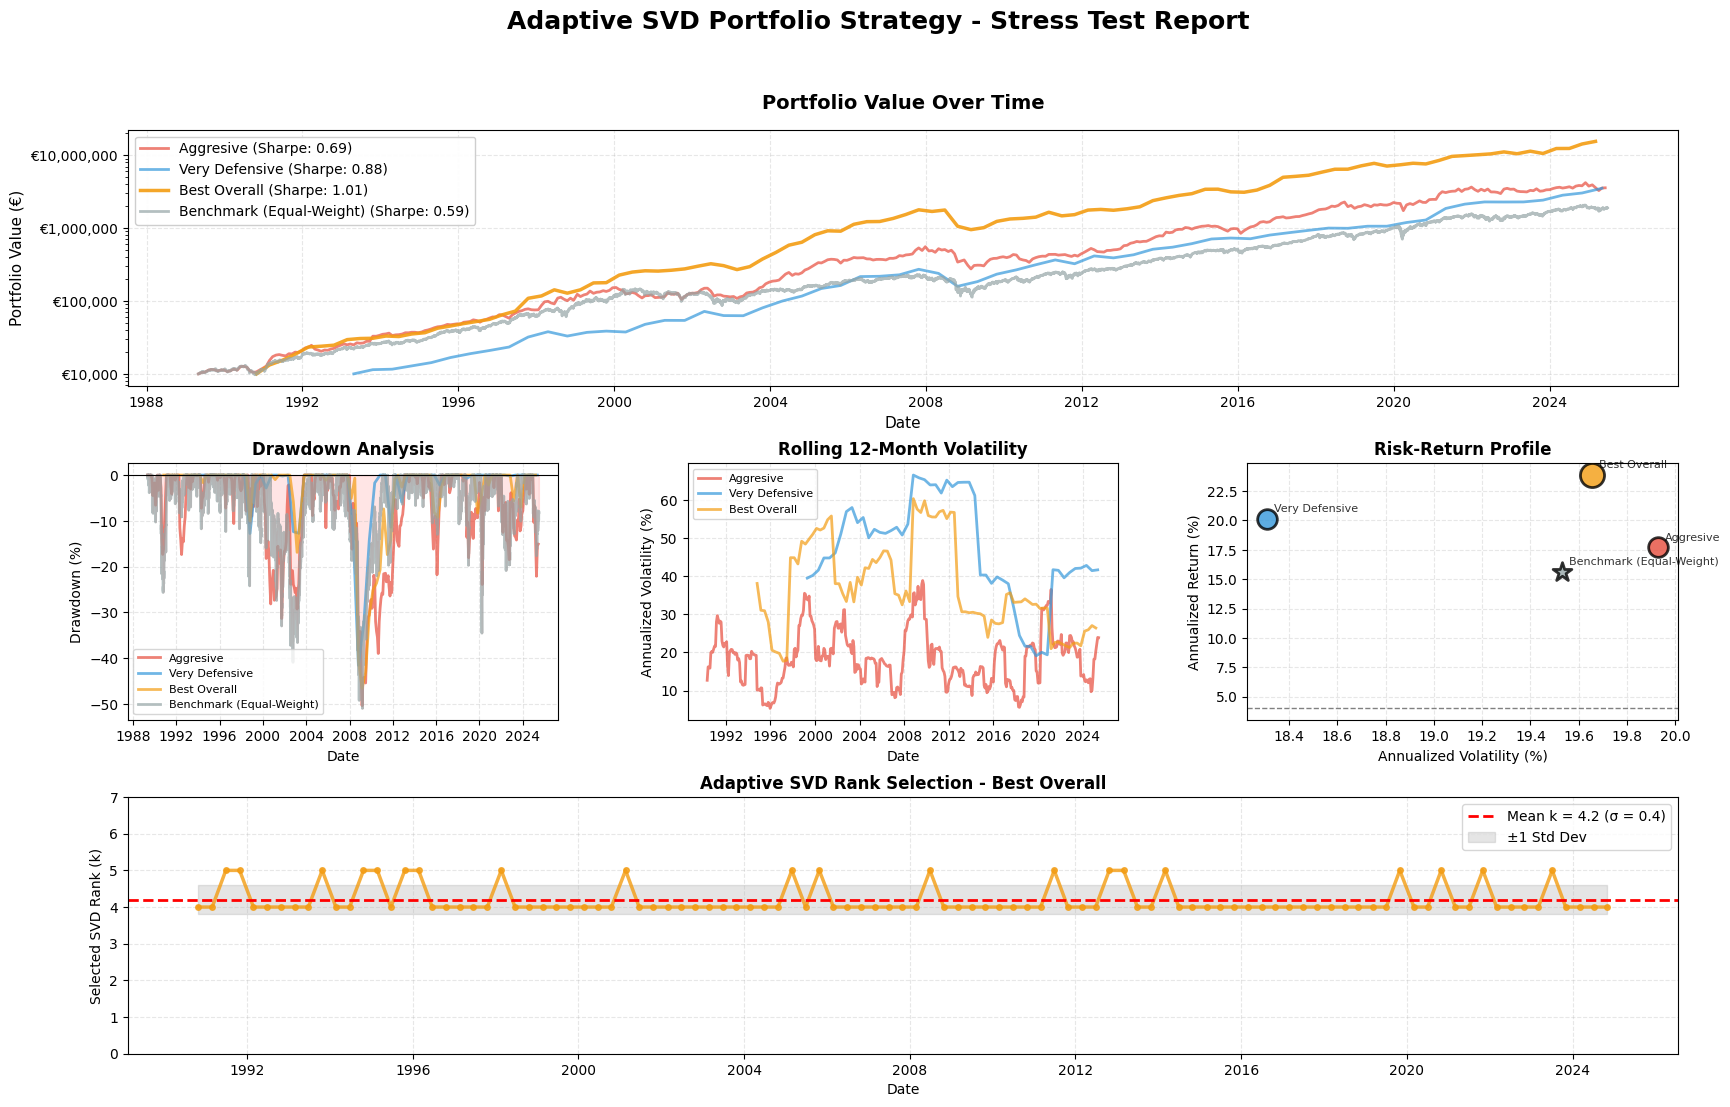


STRESS TEST COMPLETE

Key Insights:
  • Tested 3 adaptive strategies + benchmark
  • Best Sharpe: 1.010
  • Benchmark Sharpe: 0.595
  • All strategies demonstrate adaptive k selection without look-ahead bias


In [1]:
"""
SVD Portfolio Strategy - ADAPTIVE WALK-FORWARD OPTIMIZATION
Stress Test Profiles with Professional Financial Reporting
"""

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.covariance import LedoitWolf
from sklearn.utils.extmath import randomized_svd
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# STRESS TEST PROFILES
# ============================================================================

STRESS_TEST_PROFILES = [
    {
        'name': 'Aggresive',
        'train_months': 12,
        'test_months': 1,
        'short_max': 0.0,
        'momentum_weight': 0.8,
        'color': '#e74c3c'
    },
    {
        'name': 'Very Defensive',
        'train_months': 60,
        'test_months': 6,
        'short_max': 0.0,
        'momentum_weight': 0.0,
        'color': '#3498db'
    },
    {
        'name': 'Best Overall',
        'train_months': 30,
        'test_months': 4,
        'short_max': 0.0,
        'momentum_weight': 0.3,
        'color': '#f39c12'
    }
]

# Adaptive SVD Configuration
SVD_RANK_RANGE = [4,5]
VALIDATION_SPLIT = 0.7

# Constants
MAX_POSITION_SIZE = 0.15
MIN_POSITION_SIZE = 0.01
MOMENTUM_LOOKBACK = 126
RISK_FREE_RATE = 0.04
TRANSACTION_COST_BPS = 10
RANDOM_STATE = 42
TOP_N_STOCKS = 150

# ============================================================================
# DATA FUNCTIONS
# ============================================================================

def get_sp500_tickers():
    """Get S&P 500 ticker list with fallback."""
    try:
        tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
        tickers = [t.replace('.', '-') for t in tables[0]['Symbol'].tolist()]
        print(f"✓ Retrieved {len(tickers)} S&P 500 tickers")
        return tickers
    except:
        print("Using fallback ticker list...")
        return ['APD', 'AFL', 'MMM', 'ACN', 'ABBV', 'ARE', 'ALB', 'ALL', 'GOOGL', 'A',
            'AKAM', 'ABNB', 'AES', 'LNT', 'ALLE', 'AOS', 'AMD', 'ABT', 'ADBE', 'ALGN',
            'MO', 'AON', 'AMT', 'AEP', 'AMGN', 'AMCR', 'AME', 'GOOG', 'APH', 'AIG',
            'AXP', 'AMZN', 'ATO', 'ACGL', 'T', 'APTV', 'ADSK', 'AMP', 'AIZ', 'AWK',
            'AJG', 'ANET', 'AAPL', 'APO', 'ADM', 'APP', 'AMAT', 'ADI', 'APA', 'BALL',
            'AXON', 'BRK-B', 'BLK', 'BA', 'BKR', 'BBY', 'ADP', 'BIIB',
            'BAC', 'BDX', 'BAX', 'AVY', 'AVB', 'BX', 'BKNG', 'AZO', 'BK', 'BR',
            'COF', 'BSX', 'BRO', 'BF-B', 'CAT', 'CCL', 'BG', 'AVGO', 'CBOE', 'CAH',
            'CHRW', 'CPB', 'CDNS', 'C', 'CMG', 'CTAS', 'CINF', 'CB', 'CVX', 'CF',
            'COR', 'CNC', 'CHTR', 'CHD', 'CLX', 'CNP', 'SCHW', 'CDW', 'CBRE', 'CI',
            'CRL', 'CSCO', 'CFG', 'CME', 'COIN', 'CTVA', 'GLW', 'STZ', 'COO', 'CTRA',
            'KO', 'COP', 'ED', 'COST', 'CMS', 'CSGP', 'CPAY', 'CL', 'CAG', 'CTSH',
            'CPRT', 'CEG', 'CMCSA', 'DRI', 'CSX', 'DAL', 'DDOG', 'FANG', 'DVN', 'DECK',
            'DHR', 'DVA', 'DXCM', 'DLTR', 'CCI', 'DG', 'DELL', 'DE', 'CVS', 'DLR',
            'CMI', 'CRWD', 'DAY', 'DPZ', 'D', 'EIX', 'EMR', 'ELV', 'DOV', 'DUK',
            'EW', 'DTE', 'DD', 'ETN', 'ECL', 'ETR', 'EA', 'EME', 'DHI', 'EPAM',
            'EMN', 'EOG', 'EBAY', 'DASH', 'DOW', 'FFIV', 'EQIX', 'EG', 'ERIE', 'FICO',
            'EXR', 'EQT', 'EXPE', 'EXC', 'EFX', 'FAST', 'EXPD', 'EXE', 'EQR', 'ES',
            'XOM', 'EVRG', 'ESS', 'EL', 'FDS', 'FTNT', 'F', 'FITB', 'IT', 'BEN',
            'FE', 'FCX', 'FI', 'FIS', 'FOX', 'GEHC', 'FRT', 'GRMN', 'GEN', 'GEV',
            'FDX', 'FSLR', 'FTV', 'GE', 'HAS', 'HPE', 'GPC', 'GD', 'DOC', 'HSIC',
            'GILD', 'HCA', 'GPN', 'FOXA', 'HAL', 'HLT', 'HSY', 'GS', 'HIG', 'GL',
            'GDDY', 'GM', 'GIS', 'GNRC', 'IBM', 'HST', 'INTC', 'HRL', 'ITW', 'INCY',
            'HUM', 'IDXX', 'HBAN', 'IR', 'HOLX', 'IBKR', 'HD', 'IEX', 'HPQ', 'HON',
            'HII', 'PODD', 'HWM', 'ICE', 'INVH', 'ISRG', 'J', 'JBHT', 'INTU', 'IVZ',
            'IP', 'IQV', 'JPM', 'IRM', 'JNJ', 'JBL', 'IFF', 'IPG', 'HUBB', 'JCI',
            'K', 'KLAC', 'KVUE', 'KMB', 'KR', 'LII', 'KEYS', 'LIN', 'KKR', 'LHX',
            'KHC', 'JKHY', 'LLY', 'KMI', 'LDOS', 'KIM', 'LRCX', 'LVS', 'KDP', 'LEN',
            'LH', 'KEY', 'LW', 'LOW', 'MAS', 'MTCH', 'LYV', 'MA', 'LYB', 'MPC',
            'L', 'MLM', 'MMC', 'LULU', 'MKC', 'MTB', 'MAR', 'LKQ', 'LMT', 'MHK',
            'MCD', 'MGM', 'MSFT', 'MTD', 'MNST', 'MDT', 'MDLZ', 'MU', 'TAP', 'MCHP',
            'MET', 'MRK', 'MPWR', 'MCO', 'MCK', 'MOH', 'META', 'MRNA', 'MAA', 'NFLX',
            'MOS', 'MSCI', 'NKE', 'NWSA', 'NEM', 'MSI', 'NWS', 'MS', 'NEE', 'NUE',
            'NSC', 'NTAP', 'NTRS', 'NCLH', 'NRG', 'NDAQ', 'NOC', 'NDSN', 'NI', 'PLTR',
            'NXPI', 'ON', 'PH', 'PCAR', 'ORCL', 'OTIS', 'NVDA', 'PKG', 'PYPL', 'PANW',
            'OKE', 'PSKY', 'OXY', 'ORLY', 'ODFL', 'PAYC', 'NVR', 'PAYX', 'OMC', 'PPL',
            'PEG', 'PGR', 'PNC', 'PFG', 'PCG', 'PRU', 'PFE', 'PG', 'PNR', 'PSX',
            'PNW', 'PSA', 'PEP', 'PTC', 'POOL', 'PPG', 'PLD', 'PM', 'PHM', 'ROST',
            'REG', 'RVTY', 'REGN', 'HOOD', 'RMD', 'QCOM', 'RL', 'DGX', 'RJF', 'ROP',
            'RSG', 'PWR', 'ROK', 'RCL', 'SPGI', 'O', 'RF', 'RTX', 'ROL', 'CRM',
            'SWK', 'LUV', 'SHW', 'SRE', 'STT', 'SJM', 'STX', 'SPG', 'SNA', 'SOLV',
            'SBAC', 'SW', 'STLD', 'STE', 'SO', 'SBUX', 'SLB', 'SWKS', 'NOW', 'TPL',
            'TMUS', 'TMO', 'SYF', 'TXT', 'TEL', 'TTWO', 'TXN', 'TJX', 'SNPS', 'TER',
            'TDY', 'TGT', 'TSLA', 'SMCI', 'TRGP', 'TROW', 'TPR', 'TDG', 'TT', 'TSN',
            'ULTA', 'TTD', 'TRV', 'TFC', 'TYL', 'UNH', 'USB', 'TRMB', 'URI', 'SYY',
            'UAL', 'TKO', 'TSCO', 'UPS', 'UDR', 'UNP', 'WBD', 'VLTO', 'DIS', 'VTRS',
            'VRTX', 'VTR', 'UBER', 'VRSN', 'VZ', 'VMC', 'WRB', 'WMT', 'VICI', 'VRSK',
            'V', 'VLO', 'GWW', 'UHS', 'WDC', 'WMB', 'WEC', 'WELL', 'WTW', 'ZBH'
        ]


def download_data(tickers, start_date='1980-01-01', end_date='2025-06-30'):
    """Download and clean data."""
    print(f"Downloading {len(tickers)} stocks from {start_date} to {end_date}...")

    try:
        raw_data = yf.download(tickers, start=start_date, end=end_date,
                               progress=False, threads=True, group_by='column')
    except Exception as e:
        print(f"Download failed: {e}")
        return None

    if raw_data.empty:
        print("ERROR: No data downloaded")
        return None

    if isinstance(raw_data.columns, pd.MultiIndex):
        data = raw_data['Adj Close'] if 'Adj Close' in raw_data.columns.get_level_values(0) else raw_data['Close']
    else:
        data = raw_data[['Adj Close']] if 'Adj Close' in raw_data.columns else raw_data[['Close']]

    data = data.ffill().dropna(axis=1, thresh=int(0.80 * len(data)))
    data = data.dropna()

    print(f"✓ Loaded {len(data.columns)} stocks with {len(data)} trading days")
    return data


# ============================================================================
# PORTFOLIO FUNCTIONS
# ============================================================================

def calculate_momentum_scores(returns, lookback=126):
    """Calculate normalized momentum scores."""
    if len(returns) < lookback:
        return np.zeros(returns.shape[1])

    momentum_returns = returns.iloc[-lookback:].mean(axis=0)
    scores = (momentum_returns - momentum_returns.mean()) / (momentum_returns.std() + 1e-8)
    return scores.values


def get_bounds_from_short_max(n_assets, short_max, max_pos):
    """Return bounds tuple based on short_max parameter."""
    if short_max == 0.0:
        return tuple((0, max_pos) for _ in range(n_assets))
    else:
        return tuple((-short_max, max_pos) for _ in range(n_assets))


def apply_portfolio_constraints(weights, bounds, min_pos=0.01):
    """Apply constraints and clean up weights."""
    weights = np.clip(weights, bounds[0][0], bounds[0][1])
    weights[np.abs(weights) < min_pos] = 0

    if np.sum(np.abs(weights)) < 1e-8:
        return np.ones(len(weights)) / len(weights)

    weights = weights / np.sum(weights)
    return weights


def maximum_sharpe_portfolio(expected_returns, cov_matrix, bounds, risk_free_rate=0.04):
    """Calculate maximum Sharpe ratio portfolio."""
    n_assets = cov_matrix.shape[0]
    cov_matrix_reg = cov_matrix + np.eye(n_assets) * 1e-8

    def negative_sharpe(w):
        ret = np.dot(w, expected_returns)
        std = np.sqrt(np.dot(w, np.dot(cov_matrix_reg, w)))
        return -(ret - risk_free_rate) / (std + 1e-10)

    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
    initial = np.ones(n_assets) / n_assets

    try:
        result = minimize(
            negative_sharpe,
            initial,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 1000, 'ftol': 1e-9}
        )
        weights = result.x if result.success else initial
    except:
        weights = initial

    return apply_portfolio_constraints(weights, bounds, MIN_POSITION_SIZE)


def calculate_max_drawdown(cumulative_returns):
    """Calculate maximum drawdown."""
    if len(cumulative_returns) == 0:
        return 0.0

    cumulative_returns = np.array(cumulative_returns)
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - running_max) / (running_max + 1e-10)
    return np.min(drawdown)


# ============================================================================
# ADAPTIVE SVD RANK SELECTION
# ============================================================================

def compute_portfolio_sharpe(returns_data, svd_rank, momentum_weight, short_max):
    """Fast estimator using analytical solution for hyperparameter tuning."""
    try:
        train_data = returns_data.values
        n_assets = train_data.shape[1]

        expected_returns = train_data.mean(axis=0) * 252

        if momentum_weight > 0:
            momentum_scores = calculate_momentum_scores(returns_data, MOMENTUM_LOOKBACK)
            expected_returns = (1 - momentum_weight) * expected_returns + \
                               momentum_weight * momentum_scores

        lw = LedoitWolf()
        lw.fit(train_data)
        cov_lw = lw.covariance_ * 252

        std_devs = np.sqrt(np.diag(cov_lw))
        corr_matrix = cov_lw / np.outer(std_devs, std_devs)

        U, s, Vt = randomized_svd(corr_matrix,
                                  n_components=min(svd_rank, n_assets - 1),
                                  random_state=RANDOM_STATE)

        corr_svd = U @ np.diag(s) @ Vt
        cov_svd = corr_svd * np.outer(std_devs, std_devs)
        cov_svd += np.eye(n_assets) * 1e-6

        try:
            inv_cov = np.linalg.pinv(cov_svd)
            weights = inv_cov @ expected_returns
            weights = np.maximum(weights, 0)
            weights = weights / (np.sum(weights) + 1e-10)
        except:
            return -np.inf

        portfolio_return = np.dot(weights, expected_returns)
        portfolio_vol = np.sqrt(np.dot(weights, np.dot(cov_svd, weights)))

        sharpe = (portfolio_return - RISK_FREE_RATE) / (portfolio_vol + 1e-10)

        return sharpe if np.isfinite(sharpe) else -np.inf

    except Exception as e:
        return -np.inf


def select_optimal_svd_rank(train_returns, momentum_weight, short_max, k_range=SVD_RANK_RANGE):
    """Perform walk-forward validation to select optimal SVD rank."""
    n_train = len(train_returns)
    val_split_idx = int(n_train * VALIDATION_SPLIT)

    if val_split_idx < 100:
        return 10

    validation_data = train_returns.iloc[:val_split_idx]

    best_k = None
    best_sharpe = -np.inf

    for k in k_range:
        if k >= validation_data.shape[1]:
            continue

        sharpe = compute_portfolio_sharpe(validation_data, k, momentum_weight, short_max)

        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_k = k

    if best_k is None:
        best_k = 10

    return best_k


# ============================================================================
# BENCHMARK CALCULATION
# ============================================================================

def calculate_benchmark_returns(data_full, returns_full, train_months=12):
    """
    Calculate equal-weighted buy-and-hold returns for top 150 stocks.
    Rebalanced at the same frequency as strategies begin testing.
    """
    days_per_month = 21
    first_test_start = train_months * days_per_month

    if first_test_start >= len(returns_full):
        return None

    # Select top 150 volatile stocks
    train_returns_initial = returns_full.iloc[:first_test_start]
    avg_vol = train_returns_initial.abs().mean()
    selected_tickers = avg_vol.nlargest(TOP_N_STOCKS).index

    test_data = data_full.iloc[first_test_start:][selected_tickers]

    weights = np.ones(len(selected_tickers)) / len(selected_tickers)

    initial_prices = test_data.iloc[0].values
    shares = weights / initial_prices
    portfolio_values = (test_data.values @ shares)

    portfolio_values = portfolio_values / portfolio_values[0]

    dates = test_data.index

    return {
        'dates': dates,
        'cumulative_returns': portfolio_values,
        'name': 'Benchmark (Equal-Weight)',
        'color': '#95a5a6'
    }


# ============================================================================
# ADAPTIVE BACKTESTING (Modified to return time series)
# ============================================================================

def run_adaptive_backtest(returns_full, data_full, params):
    """
    Run backtest with ADAPTIVE SVD RANK SELECTION.
    Returns full time-series data for plotting.
    """
    train_months = params['train_months']
    test_months = params['test_months']
    short_max = params['short_max']
    momentum_weight = params['momentum_weight']

    try:
        total_days = len(returns_full)
        days_per_month = 21

        first_test_start = train_months * days_per_month
        remaining_days = total_days - first_test_start
        num_periods = int(remaining_days / (test_months * days_per_month))

        if num_periods < 1:
            return None

        period_returns = []
        cumulative_returns = [1.0]
        dates_list = [returns_full.index[first_test_start]]
        prev_weights = None
        selected_k_history = []

        for period_idx in range(num_periods):
            test_start_idx = first_test_start + (period_idx * test_months * days_per_month)
            test_end_idx = test_start_idx + test_months * days_per_month

            train_end_idx = test_start_idx
            train_start_idx = max(0, train_end_idx - train_months * days_per_month)

            if test_end_idx > len(returns_full):
                break

            train_returns_full = returns_full.iloc[train_start_idx:train_end_idx]

            if len(train_returns_full) < 100:
                continue

            avg_vol = train_returns_full.abs().mean()
            selected_tickers = avg_vol.nlargest(TOP_N_STOCKS).index

            train_returns = train_returns_full[selected_tickers]
            test_returns = returns_full.iloc[test_start_idx:test_end_idx][selected_tickers]
            test_prices = data_full.iloc[test_start_idx:test_end_idx][selected_tickers]

            if len(test_returns) < 10 or len(test_prices) < 10:
                continue

            optimal_k = select_optimal_svd_rank(train_returns, momentum_weight, short_max)
            selected_k_history.append({
                'period': period_idx,
                'date': returns_full.index[test_start_idx],
                'selected_k': optimal_k
            })

            train_data = train_returns.values
            n_assets = train_data.shape[1]

            expected_returns = train_data.mean(axis=0) * 252

            if momentum_weight > 0:
                momentum_scores = calculate_momentum_scores(train_returns, MOMENTUM_LOOKBACK)
                expected_returns = (1 - momentum_weight) * expected_returns + \
                                   momentum_weight * momentum_scores

            lw = LedoitWolf()
            lw.fit(train_data)
            cov_lw = lw.covariance_ * 252

            std_devs = np.sqrt(np.diag(cov_lw))
            corr_matrix = cov_lw / np.outer(std_devs, std_devs)

            U, s, Vt = randomized_svd(corr_matrix,
                                      n_components=min(optimal_k, n_assets - 1),
                                      random_state=RANDOM_STATE)

            corr_svd = U @ np.diag(s) @ Vt
            cov_svd = corr_svd * np.outer(std_devs, std_devs)

            cov_svd = (cov_svd + cov_svd.T) / 2
            min_eig = np.min(np.linalg.eigvalsh(cov_svd))
            if min_eig < 1e-8:
                cov_svd += np.eye(n_assets) * (1e-6 - min_eig)

            bounds = get_bounds_from_short_max(n_assets, short_max, MAX_POSITION_SIZE)
            weights = maximum_sharpe_portfolio(expected_returns, cov_svd, bounds, RISK_FREE_RATE)

            if prev_weights is not None:
                turnover = np.sum(np.abs(weights - prev_weights))
            else:
                turnover = np.sum(np.abs(weights))

            cost = turnover * (TRANSACTION_COST_BPS / 10000)
            prev_weights = weights.copy()

            initial_prices = test_prices.iloc[0].values
            adjusted_weights = weights * (1 - cost)
            shares = adjusted_weights / initial_prices
            portfolio_values = (test_prices.values @ shares)

            initial_value = portfolio_values[0]
            final_value = portfolio_values[-1]

            if initial_value > 0 and np.isfinite(final_value):
                period_return = (final_value / initial_value) - 1
                period_return = np.clip(period_return, -0.5, 0.5)

                period_returns.append(period_return)
                cumulative_returns.append(cumulative_returns[-1] * (1 + period_return))
                dates_list.append(returns_full.index[test_end_idx - 1])

        if len(period_returns) == 0:
            return None

        num_periods_completed = len(period_returns)
        actual_months_elapsed = num_periods_completed * test_months

        total_return = np.prod([1 + r for r in period_returns]) - 1
        annualized_return = (1 + total_return) ** (12 / actual_months_elapsed) - 1

        period_vol = np.std(period_returns)
        annualized_vol = period_vol * np.sqrt(12 / test_months)

        sharpe = (annualized_return - RISK_FREE_RATE) / (annualized_vol + 1e-10)
        max_dd = calculate_max_drawdown(cumulative_returns)

        return {
            'sharpe': sharpe,
            'return': annualized_return,
            'volatility': annualized_vol,
            'max_drawdown': max_dd,
            'num_periods': num_periods_completed,
            'total_months': actual_months_elapsed,
            'selected_k_history': selected_k_history,
            'avg_k': np.mean([x['selected_k'] for x in selected_k_history]),
            'std_k': np.std([x['selected_k'] for x in selected_k_history]),
            'dates': dates_list,
            'cumulative_returns': cumulative_returns
        }

    except Exception as e:
        print(f"    Error in backtest: {e}")
        return None


# ============================================================================
# STRESS TEST RUNNER
# ============================================================================

def run_stress_tests(returns, data):
    """Run the 4 predefined stress test profiles."""

    print(f"\n{'='*100}")
    print(f"STRESS TEST PROFILES: {len(STRESS_TEST_PROFILES)} strategies + Benchmark")
    print(f"{'='*100}\n")

    results = []

    for idx, profile in enumerate(STRESS_TEST_PROFILES, 1):
        name = profile['name']

        print(f"[{idx}/{len(STRESS_TEST_PROFILES)}] Running: {name}")
        print(f"    Params: Train={profile['train_months']}m, "
              f"Test={profile['test_months']}m, "
              f"Short={profile['short_max']:.1f}, "
              f"Mom={profile['momentum_weight']:.1f}")

        result = run_adaptive_backtest(returns, data, profile)

        if result is not None:
            result.update({
                'name': name,
                'color': profile['color'],
                'train_months': profile['train_months'],
                'test_months': profile['test_months'],
                'short_max': profile['short_max'],
                'momentum_weight': profile['momentum_weight']
            })
            results.append(result)

            print(f"    ✓ Sharpe={result['sharpe']:.3f}, "
                  f"Return={result['return']*100:.2f}%, "
                  f"Vol={result['volatility']*100:.2f}%, "
                  f"MaxDD={result['max_drawdown']*100:.2f}%")
            print(f"    ✓ Avg k={result['avg_k']:.1f} ± {result['std_k']:.1f}\n")
        else:
            print(f"    ✗ Failed\n")

    # Add benchmark
    print("[4/4] Calculating Benchmark (Equal-Weight Buy-and-Hold)")
    benchmark = calculate_benchmark_returns(data, returns, train_months=12)

    if benchmark is not None:
        # Calculate benchmark metrics
        cum_rets = benchmark['cumulative_returns']
        dates = benchmark['dates']

        # Convert to period returns
        period_returns = np.diff(cum_rets) / cum_rets[:-1]

        total_return = cum_rets[-1] - 1
        years = (dates[-1] - dates[0]).days / 365.25
        annualized_return = (1 + total_return) ** (1 / years) - 1
        annualized_vol = np.std(period_returns) * np.sqrt(252)
        sharpe = (annualized_return - RISK_FREE_RATE) / (annualized_vol + 1e-10)
        max_dd = calculate_max_drawdown(cum_rets)

        benchmark.update({
            'sharpe': sharpe,
            'return': annualized_return,
            'volatility': annualized_vol,
            'max_drawdown': max_dd,
            'train_months': 0,
            'test_months': 0,
            'short_max': 0,
            'momentum_weight': 0,
            'avg_k': 0,
            'std_k': 0
        })

        results.append(benchmark)
        print(f"    ✓ Sharpe={sharpe:.3f}, "
              f"Return={annualized_return*100:.2f}%, "
              f"Vol={annualized_vol*100:.2f}%, "
              f"MaxDD={max_dd*100:.2f}%\n")

    return results


# ============================================================================
# PROFESSIONAL VISUALIZATION
# ============================================================================

def plot_stress_test_results(results_list, save_path='stress_test_report.png'):
    """
    Create professional financial dashboard with 5 key charts.
    """
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    fig.suptitle('Adaptive SVD Portfolio Strategy - Stress Test Report',
                 fontsize=18, fontweight='bold', y=0.98)

    INITIAL_CAPITAL = 10000  # €10,000

    # ========================================================================
    # PLOT 1: Equity Curve (Rebased to €10,000)
    # ========================================================================
    ax1 = fig.add_subplot(gs[0, :])

    for result in results_list:
        dates = result['dates']
        cum_returns = np.array(result['cumulative_returns'])
        portfolio_value = cum_returns * INITIAL_CAPITAL

        ax1.plot(dates, portfolio_value,
                linewidth=2.5 if result['name'] == 'Best Overall' else 2,
                alpha=0.9 if result['name'] == 'Best Overall' else 0.7,
                color=result['color'],
                label=f"{result['name']} (Sharpe: {result['sharpe']:.2f})")

    ax1.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel('Date', fontsize=11)
    ax1.set_ylabel('Portfolio Value (€)', fontsize=11)
    ax1.legend(loc='upper left', fontsize=10, framealpha=0.95)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_yscale('log')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:,.0f}'))

    # ========================================================================
    # PLOT 2: Drawdown Over Time
    # ========================================================================
    ax2 = fig.add_subplot(gs[1, 0])

    for result in results_list:
        dates = result['dates']
        cum_returns = np.array(result['cumulative_returns'])

        running_max = np.maximum.accumulate(cum_returns)
        drawdown = (cum_returns - running_max) / running_max * 100

        ax2.plot(dates, drawdown,
                linewidth=2,
                alpha=0.7,
                color=result['color'],
                label=result['name'])

    ax2.fill_between(dates, 0, drawdown, alpha=0.1, color='red')
    ax2.set_title('Drawdown Analysis', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=10)
    ax2.set_ylabel('Drawdown (%)', fontsize=10)
    ax2.legend(loc='lower left', fontsize=8)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

    # ========================================================================
    # PLOT 3: Rolling Volatility (12-month)
    # ========================================================================
    ax3 = fig.add_subplot(gs[1, 1])

    for result in results_list:
        if result['name'] == 'Benchmark (Equal-Weight)':
            continue  # Skip benchmark for volatility plot

        dates = result['dates']
        cum_returns = np.array(result['cumulative_returns'])

        # Calculate rolling returns
        returns = np.diff(cum_returns) / cum_returns[:-1]

        # 12-month rolling volatility (annualized)
        window = min(12, len(returns) // 2)
        if window > 2:
            rolling_vol = pd.Series(returns).rolling(window).std() * np.sqrt(12) * 100

            ax3.plot(dates[1:], rolling_vol,
                    linewidth=2,
                    alpha=0.7,
                    color=result['color'],
                    label=result['name'])

    ax3.set_title('Rolling 12-Month Volatility', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Date', fontsize=10)
    ax3.set_ylabel('Annualized Volatility (%)', fontsize=10)
    ax3.legend(loc='upper left', fontsize=8)
    ax3.grid(True, alpha=0.3, linestyle='--')

    # ========================================================================
    # PLOT 4: Risk-Return Scatter
    # ========================================================================
    ax4 = fig.add_subplot(gs[1, 2])

    for result in results_list:
        vol = result['volatility'] * 100
        ret = result['return'] * 100

        size = 300 if result['name'] == 'Best Overall' else 200
        marker = '*' if result['name'] == 'Benchmark (Equal-Weight)' else 'o'

        ax4.scatter(vol, ret,
                   s=size,
                   c=result['color'],
                   alpha=0.8,
                   edgecolors='black',
                   linewidth=2,
                   marker=marker,
                   label=result['name'],
                   zorder=5 if result['name'] == 'Best Overall' else 3)

        # Add labels
        ax4.annotate(result['name'],
                    (vol, ret),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=8,
                    alpha=0.8)

    ax4.set_title('Risk-Return Profile', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Annualized Volatility (%)', fontsize=10)
    ax4.set_ylabel('Annualized Return (%)', fontsize=10)
    ax4.grid(True, alpha=0.3, linestyle='--')
    ax4.axhline(y=RISK_FREE_RATE*100, color='gray', linestyle='--',
                linewidth=1, label=f'Risk-Free Rate ({RISK_FREE_RATE*100:.1f}%)')

    # ========================================================================
    # PLOT 5: Adaptive K History (Golden Mean only)
    # ========================================================================
    ax5 = fig.add_subplot(gs[2, :])

    best_mean = [r for r in results_list if r['name'] == 'Best Overall'][0]
    k_history = best_mean['selected_k_history']

    dates = [x['date'] for x in k_history]
    k_values = [x['selected_k'] for x in k_history]

    ax5.plot(dates, k_values,
            linewidth=2.5,
            color='#f39c12',
            alpha=0.8,
            marker='o',
            markersize=4)

    ax5.axhline(y=np.mean(k_values),
               color='red',
               linestyle='--',
               linewidth=2,
               label=f'Mean k = {np.mean(k_values):.1f} (σ = {np.std(k_values):.1f})')

    ax5.fill_between(dates,
                     np.mean(k_values) - np.std(k_values),
                     np.mean(k_values) + np.std(k_values),
                     alpha=0.2,
                     color='gray',
                     label='±1 Std Dev')

    ax5.set_title('Adaptive SVD Rank Selection - Best Overall',
                 fontsize=12, fontweight='bold')
    ax5.set_xlabel('Date', fontsize=10)
    ax5.set_ylabel('Selected SVD Rank (k)', fontsize=10)
    ax5.legend(loc='upper right', fontsize=10)
    ax5.grid(True, alpha=0.3, linestyle='--')
    ax5.set_ylim([0, max(SVD_RANK_RANGE) + 2])

    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Professional report saved to '{save_path}'")
    plt.show()


def print_stress_test_summary(results_list):
    """Print professional summary table."""
    print(f"\n{'='*100}")
    print(f"STRESS TEST SUMMARY")
    print(f"{'='*100}\n")

    # Sort by Sharpe (strategies only)
    strategies = [r for r in results_list if 'selected_k_history' in r]
    strategies_sorted = sorted(strategies, key=lambda x: x['sharpe'], reverse=True)

    # Add benchmark at the end
    benchmark = [r for r in results_list if r['name'] == 'Benchmark (Equal-Weight)']
    all_results = strategies_sorted + benchmark

    for idx, result in enumerate(all_results, 1):
        print(f"{idx}. {result['name']}")

        if result['name'] != 'Benchmark (Equal-Weight)':
            print(f"   Parameters: Train={int(result['train_months'])}m, "
                  f"Test={int(result['test_months'])}m, "
                  f"Short={result['short_max']:.1f}, "
                  f"Mom={result['momentum_weight']:.1f}")
            print(f"   Adaptive k: {result['avg_k']:.1f} ± {result['std_k']:.1f}")

        print(f"   Sharpe Ratio: {result['sharpe']:.3f}")
        print(f"   Ann. Return: {result['return']*100:.2f}%")
        print(f"   Ann. Volatility: {result['volatility']*100:.2f}%")
        print(f"   Max Drawdown: {result['max_drawdown']*100:.2f}%")
        print()


# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution - Stress Test Profiles."""
    print("="*100)
    print("SVD PORTFOLIO STRATEGY - STRESS TEST PROFILES")
    print("Professional Financial Reporting with Adaptive Optimization")
    print("="*100)

    # Download data
    tickers = get_sp500_tickers()
    data = download_data(tickers, start_date='1980-01-01', end_date='2025-06-30')

    if data is None or data.empty:
        print("ERROR: No data available")
        return

    returns = data.pct_change().dropna()
    print(f"\nUniverse: {len(returns.columns)} stocks, {len(returns)} trading days")
    print(f"Date range: {returns.index[0].date()} to {returns.index[-1].date()}")
    print(f"SVD Rank: ADAPTIVE (validated from range {min(SVD_RANK_RANGE)}-{max(SVD_RANK_RANGE)})")

    # Run stress tests
    results_list = run_stress_tests(returns, data)

    if not results_list:
        print("\nERROR: No successful backtests")
        return

    # Print summary
    print_stress_test_summary(results_list)

    # Generate professional visualizations
    print(f"\n{'='*100}")
    print("GENERATING PROFESSIONAL FINANCIAL REPORT")
    print(f"{'='*100}")
    plot_stress_test_results(results_list)

    print(f"\n{'='*100}")
    print("STRESS TEST COMPLETE")
    print(f"{'='*100}")
    print("\nKey Insights:")
    print(f"  • Tested {len(results_list)-1} adaptive strategies + benchmark")
    print(f"  • Best Sharpe: {max([r['sharpe'] for r in results_list if 'selected_k_history' in r]):.3f}")
    print(f"  • Benchmark Sharpe: {[r['sharpe'] for r in results_list if r['name'] == 'Benchmark (Equal-Weight)'][0]:.3f}")
    print(f"  • All strategies demonstrate adaptive k selection without look-ahead bias")


if __name__ == '__main__':
    main()